In [1]:
library(psych)
library(rpart)
library("pROC")
library(randomForest)
library(xgboost)
library(caret)

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:psych’:

    outlier


Loading required package: lattice

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin


The following objects are masked from ‘package:psych’:

    %+%, alpha



Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress




In [2]:
wine_data<-read.table("../input/winequality/winequality-red.csv", sep=";", header=TRUE)
wine_data$quality <- I(wine_data$quality > 6) * 1
head(wine_data)
dim(wine_data)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<I<dbl>>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,0
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,0
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,0
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,0
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,0
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,0


[1] 1599   12

In [3]:
#Split the data into test and train sets 
set.seed(42)
trn <- runif(nrow(wine_data)) < .7
train <- data.frame(wine_data[trn==TRUE,])
test <- data.frame(wine_data[trn==FALSE,])
Y_test <- test$quality
dim(train)

[1] 1136   12

In [4]:
#xvars<-names(wine_data)[-12]

In [5]:
#Fit a random forest to the data
X<-as.matrix(train[,-12])
Y<-factor(train$quality)
mtry<-(ncol(X)^0.5)
ntree <- 1000
set.seed(652)
rf1 <- randomForest(x=X, y=Y, ntree=ntree, mtry=mtry, importance=TRUE)
rf1


Call:
 randomForest(x = X, y = Y, ntree = ntree, mtry = mtry, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 3

        OOB estimate of  error rate: 8.89%
Confusion matrix:
    0  1 class.error
0 961 23  0.02337398
1  78 74  0.51315789

In [6]:
summary(rf1)
names(rf1)

                Length Class  Mode     
call               6   -none- call     
type               1   -none- character
predicted       1136   factor numeric  
err.rate        3000   -none- numeric  
confusion          6   -none- numeric  
votes           2272   matrix numeric  
oob.times       1136   -none- numeric  
classes            2   -none- character
importance        44   -none- numeric  
importanceSD      33   -none- numeric  
localImportance    0   -none- NULL     
proximity          0   -none- NULL     
ntree              1   -none- numeric  
mtry               1   -none- numeric  
forest            14   -none- list     
y               1136   factor numeric  
test               0   -none- NULL     
inbag              0   -none- NULL     

[1] "call"            "type"            "predicted"       "err.rate"       
 [5] "confusion"       "votes"           "oob.times"       "classes"        
 [9] "importance"      "importanceSD"    "localImportance" "proximity"      
[13] "ntree"           "mtry"            "forest"          "y"              
[17] "test"            "inbag"

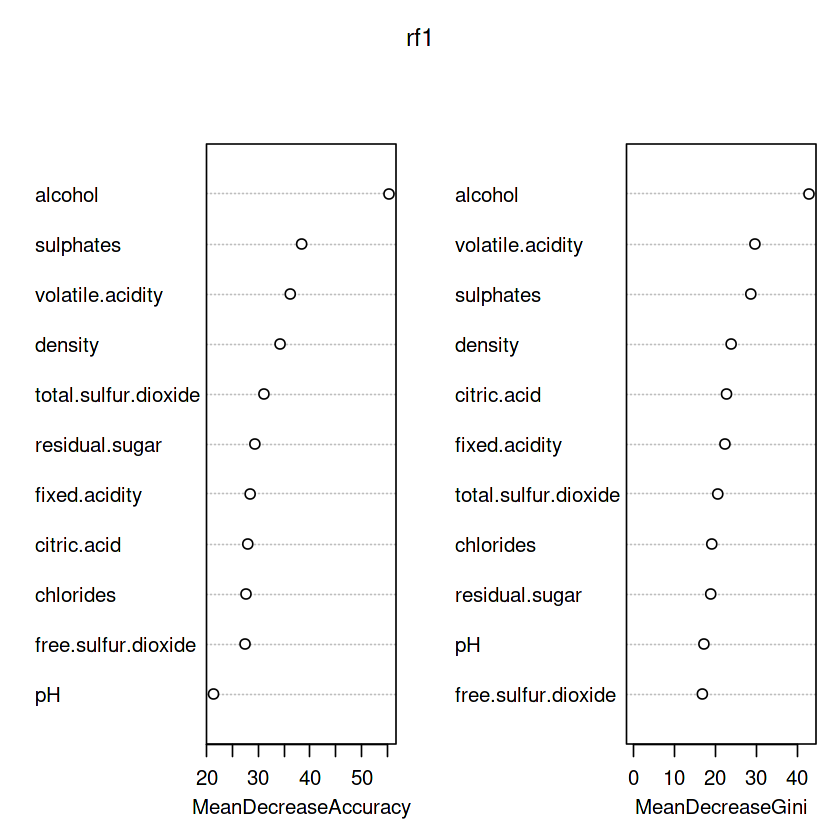

In [7]:
varImpPlot(rf1)

In [8]:
#Use random forest model to make predictions in the test data 
pred.rf1 <- predict(rf1, test)
table(pred.rf1, test$quality)

        
pred.rf1   0   1
       0 392  33
       1   6  32

In [9]:
yhat.rf1 <- predict(rf1, test, type="prob")[,2]

Setting levels: control = 0, case = 1




Call:
roc.default(response = test$quality, predictor = yhat.rf1, direction = "<")

Data: yhat.rf1 in 398 controls (test$quality 0) < 65 cases (test$quality 1).
Area under the curve: 0.9298

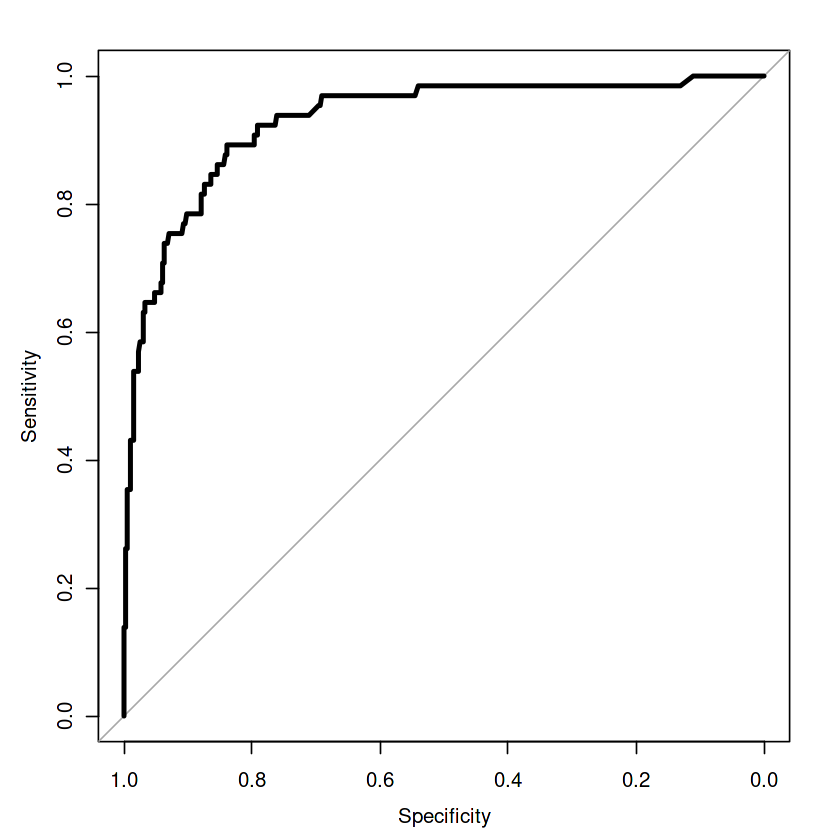

In [10]:
rf1.roc <- roc(test$quality, yhat.rf1, direction="<")
rf1.roc
plot(rf1.roc, lwd=3)

In [11]:
#Fit a boosted tree learner to the data
X.tst <- as.matrix(test[,-12])

parm <- list(nthread=2, max_depth=2, eta=0.10)
bt1 <- xgboost(parm, data=X, label=train$quality, verbose=2, objective='binary:logistic', nrounds=12)


[00:43:44] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[1]	train-logloss:0.500351 
[2]	train-logloss:0.390099 
[3]	train-logloss:0.318105 
[4]	train-logloss:0.266142 
[5]	train-logloss:0.229816 
[6]	train-logloss:0.201930 
[7]	train-logloss:0.181230 
[8]	train-logloss:0.162817 
[9]	train-logloss:0.150298 
[10]	train-logloss:0.140787 
[11]	train-logloss:0.134265 
[12]	train-logloss:0.128395 


In [12]:
imp <- xgb.importance(feature_names=colnames(X), model=bt1)
imp[1:10,]

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
alcohol,0.30190346,0.27912951,0.09929078
sulphates,0.14361710,0.11924453,0.09929078
total.sulfur.dioxide,0.09393047,0.08708768,0.12765957
volatile.acidity,0.08818789,0.14484868,0.10283688
fixed.acidity,0.07120806,0.06528212,0.09574468
free.sulfur.dioxide,0.06690963,0.03178028,0.08510638
residual.sugar,0.06493739,0.06747584,0.09574468
density,0.05317739,0.05510608,0.08865248
pH,0.04656648,0.02539856,0.06737589


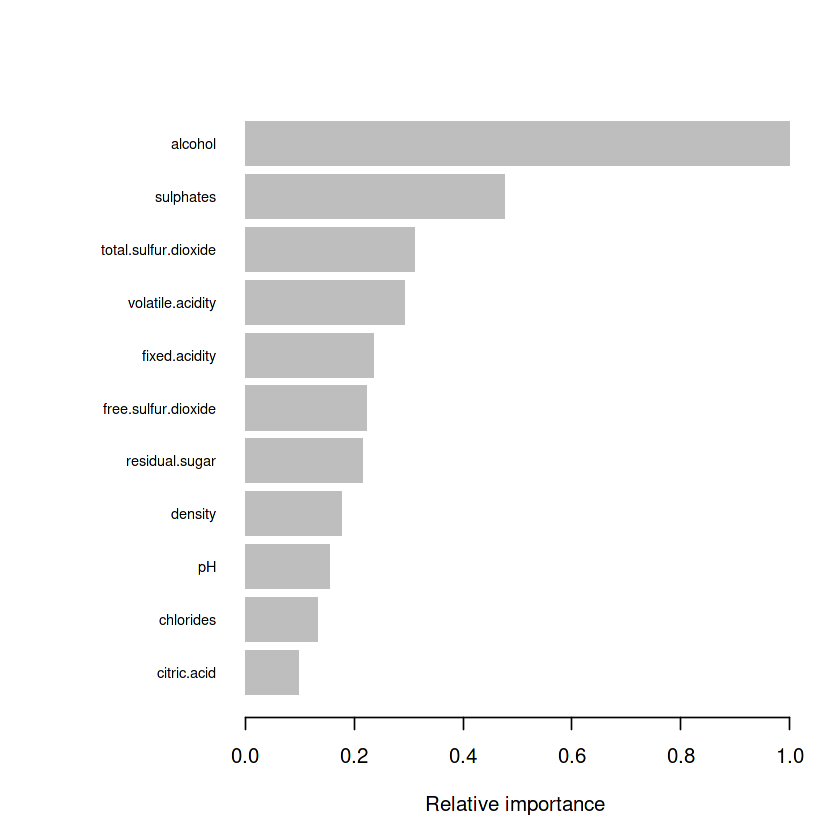

In [13]:
xgb.plot.importance(imp, rel_to_first = TRUE, xlab = "Relative importance")

In [14]:
#Confusion Matrix
yhat.bt1 <- predict(bt1, X.tst) 
table(yhat.bt1 > 0.5, test$quality)

       
          0   1
  FALSE 382  28
  TRUE   16  37

In [15]:
bt1.roc <- roc(test$quality, yhat.bt1, direction="<")
bt1.roc

Setting levels: control = 0, case = 1




Call:
roc.default(response = test$quality, predictor = yhat.bt1, direction = "<")

Data: yhat.bt1 in 398 controls (test$quality 0) < 65 cases (test$quality 1).
Area under the curve: 0.9127

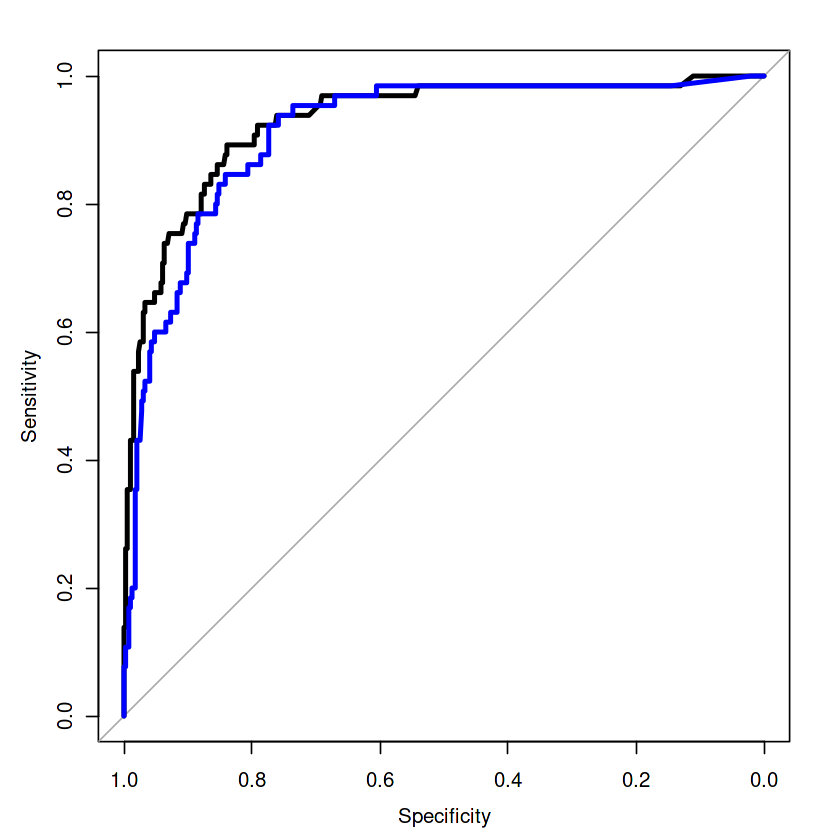

In [16]:
plot(rf1.roc, lwd=3)
#lines(abt1.roc, col="red", lwd=3)
lines(bt1.roc, col="blue", lwd=3)

In [17]:
#Tuning the parameters
set.seed(42) #varies quite a bit
ctrl <- trainControl(method="cv", number=10, search="random")
model <- train(factor(quality)~., data=train, method="xgbTree", trControl=ctrl)
model

eXtreme Gradient Boosting 

1136 samples
  11 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1023, 1023, 1022, 1023, 1022, 1023, ... 
Resampling results across tuning parameters:

  eta        max_depth  gamma     colsample_bytree  min_child_weight  subsample
  0.2751873  10         2.554288  0.6912906         14                0.9600012
  0.3945384   4         7.191123  0.4849171         19                0.3540326
  0.4233338   2         9.346722  0.6760058         17                0.9916688
  nrounds  Accuracy   Kappa    
   74      0.8811598  0.3739643
  321      0.8732495  0.2111881
  153      0.8732495  0.2647956

Accuracy was used to select the optimal model using the largest value.
The final values used for the model were nrounds = 74, max_depth = 10, eta
 = 0.2751873, gamma = 2.554288, colsample_bytree = 0.6912906,
 min_child_weight = 14 and subsample = 0.9600012.

In [18]:
parm <- list(nthread=2, max_depth=10, eta=0.2752, gamma=2.55, min_child_weight=14, subsample=.96)
bt2 <- xgboost(parm, data=X, label=train$quality, verbose=2, objective='binary:logistic', nrounds=74)

[00:43:49] WARNING: amalgamation/../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[1]	train-logloss:0.500351 
[2]	train-logloss:0.390099 
[3]	train-logloss:0.318105 
[4]	train-logloss:0.266142 
[5]	train-logloss:0.229816 
[6]	train-logloss:0.201930 
[7]	train-logloss:0.181230 
[8]	train-logloss:0.162817 
[9]	train-logloss:0.150298 
[10]	train-logloss:0.140787 
[11]	train-logloss:0.134265 
[12]	train-logloss:0.128395 
[13]	train-logloss:0.123745 
[14]	train-logloss:0.118042 
[15]	train-logloss:0.110026 
[16]	train-logloss:0.101895 
[17]	train-logloss:0.096457 
[18]	train-logloss:0.092485 
[19]	train-logloss:0.090404 
[20]	train-logloss:0.083564 
[21]	train-logloss:0.079469 
[22]	train-logloss:0.075963 
[23]	train-logloss:0.071782 
[24]	train-logloss:0.067006 
[25]	train-logloss:0.063737 
[26]	train-logloss:

In [19]:
#Confusion Matrix
yhat.bt2 <- predict(bt2, X.tst) 
table(yhat.bt2 > 0.5, test$quality)

       
          0   1
  FALSE 385  27
  TRUE   13  38

In [20]:
bt2.roc <- roc(test$quality, yhat.bt2, direction="<")
bt2.roc

Setting levels: control = 0, case = 1




Call:
roc.default(response = test$quality, predictor = yhat.bt2, direction = "<")

Data: yhat.bt2 in 398 controls (test$quality 0) < 65 cases (test$quality 1).
Area under the curve: 0.9341

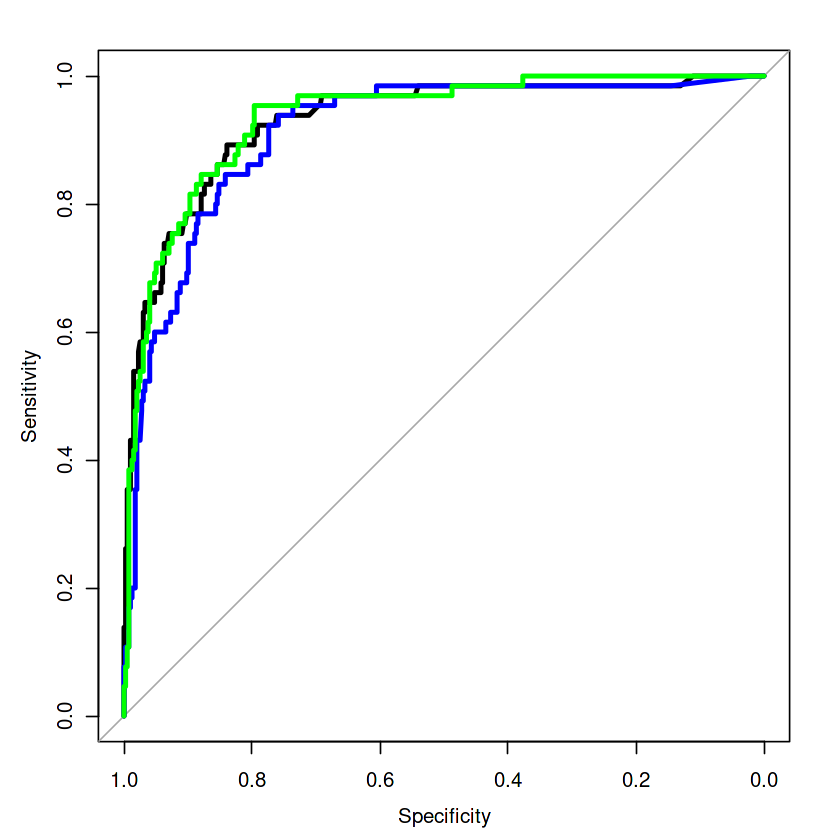

In [21]:
plot(rf1.roc, lwd=3)
#lines(abt1.roc, col="red", lwd=3)
lines(bt1.roc, col="blue", lwd=3)
lines(bt2.roc, col="green", lwd=3)